## Introduction to data-driven model development



So far we have primarily focused on data; reading it in, filtering it, plotting it, etc. This is a precursor to being able to build models from your data.

We need models for several purposes:

1.  We can use models to make predictions for new inputs
2.  Some models are physics based, and we can interpret them to better understand the data
3.  With a model, we can help determine if new data is consistent with old data

There are two classes of models: linear and nonlinear. Linear means that the predicted values are *linear* in the inputs, i.e.

$y = \sum a_i x_i$

where $a_i$ are the model parameters, and $x_i$ are the input variables.

Everything else is considered a nonlinear model, and that means the output of the model has a nonlinear dependence on the model parameters.

Today, we will do a brief review of linear models.

We will be using data from the NIST web book 'Thermophysical Properties
of Fluid Systems': [https://webbook.nist.gov/chemistry/fluid/](https://webbook.nist.gov/chemistry/fluid/)

Specifically, the data used here contains the properties of water at isochoric conditions and a density of 1000 kg/m3, between 0C to 100C. This data can be downloaded once we enter the fluid conditions in the above link.



### Initial view of the data



Here is the data we have to work with.



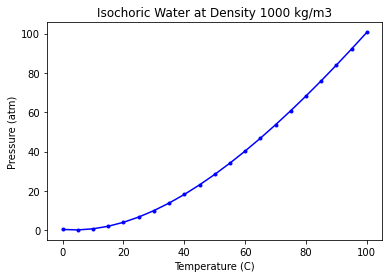

In [1]:
import numpy as np
import matplotlib.pyplot as plt

T, P = np.loadtxt('fluid.txt', delimiter='\t',
                  skiprows = 1, usecols=(0, 1),
                  unpack=True)

plt.plot(T, P, 'b.-')
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (atm)')
plt.title("Isochoric Water at Density 1000 kg/m3");

Our goal is to develop a model from this data that allows us to make predictions in this temperature range.

There are many options:

1.  Interpolation
2.  Fitting an equation

We will focus on the second option here, which is fitting an equation, and in particular we are interested in linear models today.



### np.polyfit



The most common linear model is a simple polynomial. We can do this in Numpy like this.



In [1]:
pars = np.polyfit(T, P, 2)
pars

array([ 0.00883907,  0.15490404, -1.55802977])

As a reminder, these parameters are for the powers ($T^2, T, 1$).

We evaluate the fit here in a qualitative way.



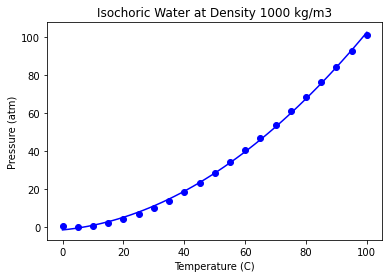

In [1]:
tfit = np.linspace(T.min(), T.max())
pfit = np.polyval(pars, tfit)

plt.plot(T, P, 'bo', tfit, pfit, 'b-')
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (atm)')
plt.title("Isochoric Water at Density 1000 kg/m3");

The fit looks ok, but let's check the residual errors.



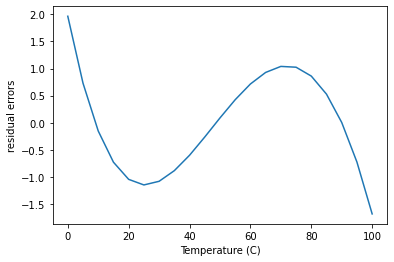

In [1]:
plt.plot(T, (P - np.polyval(pars, T)))
plt.xlabel('Temperature (C)')
plt.ylabel('residual errors');

The first thing to note about this is the errors are relatively small in the absolute sense over the range of the Pressure data. The error is worse in a relative sense at low pressure, but small at high pressure.

This plot also shows that the errors are not random; there are clear trends as a function of x, which means this model does not describe the data perfectly. In some regions there are systematic underestimates, and in others systematic overestimates.

`np.polyfit` is convenient, but it lacks many useful features we need. First, it is limited to polynomials, and we might want additional inputs that are not simple powers of $x$, e.g. $1/x$.

Second, we cannot eliminate any terms in the polynomial.



### A generalized numpy approach to linear regression



We can address these with a more generalized linear regression approach.

We will focus on using standard numpy functions.



In [1]:
X = np.array([T**2, T, T**0]).T

pars1, resid, rank, sv = np.linalg.lstsq(X, P, rcond=None)
pars1

array([ 0.00883907,  0.15490404, -1.55802977])

As expected, these parameters are the same as before. Now, however, we are free to add as many columns as we want, for example, here we add T\*\*3, and $log(T)$ and remove T. This reduces the magnitude of the errors, but still shows some systematic variations.



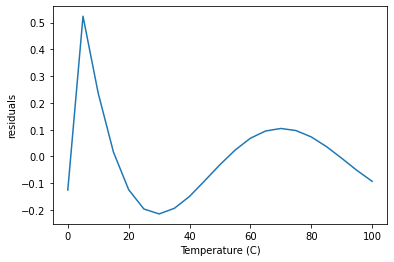

In [1]:
X = np.array([T**3, T**2, T**0, np.log(T)]).T

pars2, resid, rank, sv = np.linalg.lstsq(X, P, rcond=None)

plt.plot(T, P - X @ pars2)
plt.xlabel('Temperature (C)')
plt.ylabel('residuals');

This approach offers a lot of flexibility, but still lacks some desired ease of use. For example:

1.  What features should we use?
2.  How do we know if an input is necessary or not?

In the work above, we used all of the data in our fitting, and we have no way to evaluate the quality of the models on data that was not included in the fit.

All of these issues are addressed in modern machine learning frameworks. These frameworks automate the development of models from data.

There are several machine learning frameworks. The most common ones are:

1.  scikit-learn ([https://scikit-learn.org/stable/](https://scikit-learn.org/stable/))
2.  Tensorflow ([https://www.tensorflow.org/](https://www.tensorflow.org/))
3.  Pytorch ([https://pytorch.org/](https://pytorch.org/))



## scikit-learn



We will focus on scikit-learn. It is already installed on Deepnote. [scikit-learn](https://scikit-learn.org/stable/user_guide.html) is large, so we will only consider a few paths through it.

When we use scikit-learn we create a model, then we *fit* the model to data. After the fit, we can use the model to *predict* values.

It is common to split the available data into two sets, one for *fitting* or *training*, and one for *testing*. Let's do this first.



### Splitting the data into training and test data



The key points in splitting the data is that we want to *randomly* select data for the fitting, and use the rest for testing. We have to choose a split, e.g. 80% for fitting and 20% for testing. There is no magic in this, it is just a choice. The important thing is that these two sets are similar, and representative of the data.

We make an array of columns for the X data here, where each column is considered a *feature* that we think the output $y$ is related to. `sklearn` makes it easy to split the data, here we use 20% for testing.



In [1]:
from sklearn.model_selection import train_test_split

X = np.array([T**3, T**2, T, T**0]).T
y = P

(X_train, X_test,
 y_train, y_test) = train_test_split(X, y,
                                     test_size=0.2,
                                     shuffle=True,
                                     random_state=42)

Let's see what we got, first let's look at the shapes.



In [1]:
X_train.shape, X_test.shape

| 16 | 4 |
|  5 | 4 |

In [1]:
y_train.shape, y_test.shape

| 16 |
|  5 |

We should also see if we can visualize where the selection occurred. Here, we plot the train and test data, and we plot these two sets.



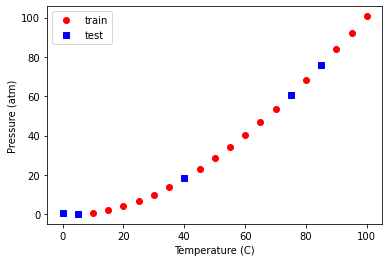

In [1]:
plt.plot(X_train[:, 2], y_train, 'ro',
         X_test[:, 2], y_test, 'bs')
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (atm)')
plt.legend(['train', 'test']);

You should see the same thing because we used a random seed. If you set it to a different value, you will get a different set of points. It might seem odd that you always get the same random numbers but:

1.  The numbers are not random, they are psuedorandom
2.  This is the same as reading a list of numbers of the page of a book
3.  It is helpful because it means we get the same data every time, which makes our work reproducible.



### Choosing a model



The task we are doing is called *supervised learning*, which means we know what the answers are, and we use an algorithm to find the relationship between the inputs and the outputs. See [https://scikit-learn.org/stable/supervised_learning.html>](https://scikit-learn.org/stable/supervised_learning.html>)for a very long list of models. For now, we focus on a [linear model](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares). This is the simplest way to fit the train data.



In [1]:
from sklearn import linear_model
model = linear_model.LinearRegression()

model.fit(X_train, y_train)
model.coef_

array([-4.03111876e-05,  1.48141559e-02, -7.18950227e-02,  0.00000000e+00])

It is straightforward to see how the model fits. The only tricky thing is making sure to use the right "x" values for the train and test data. Luckily, that is one of the columns in the X array, so we just use that.



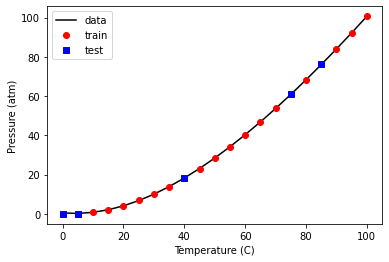

In [1]:
plt.plot(T, P, 'k-',
         X_train[:, 2], model.predict(X_train), 'ro',
         X_test[:, 2], model.predict(X_test), 'bs')
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (atm)')
plt.legend(['data', 'train', 'test']);

That fit looks good, and the score indicates it is very good.



In [1]:
model.score(X_train, y_train)

0.9999974771711627

Note, this is just a polynomial model, so you should not use it with extrapolation. Despite fitting it with a library that suggests machine learning has happened, *there are no physics* in this model. It does not behave correctly at low nor very high temperature.



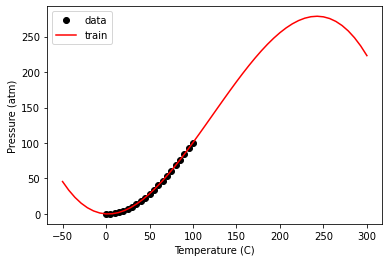

In [1]:
Tex = np.linspace(-50, 300)
Xex = np.array([Tex**3, Tex**2, Tex, Tex**0]).T

plt.plot(T, P, 'ko',
         Xex[:, 2], model.predict(Xex), 'r-')
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (atm)')
plt.legend(['data', 'train', 'test']);

Within the data range, it is reasonable though. Let's examine the residual errors.



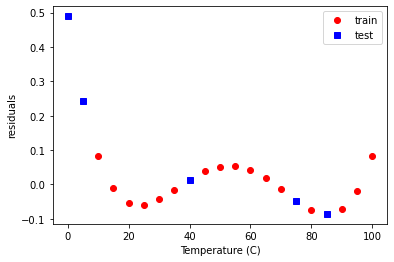

In [1]:
plt.plot(X_train[:, 2], y_train - model.predict(X_train), 'ro',
         X_test[:, 2], y_test - model.predict(X_test), 'bs')
plt.xlabel('Temperature (C)')
plt.ylabel('residuals')
plt.legend(['train', 'test']);

As before, we see non-random, temperature dependent distributions of the errors, indicating they are systematic, and the model is still inadequate to fully model this data.

Up to this point, we have just replaced the numpy methods with sklearn methods. sklearn is to model building much like pandas is for data. It provides a consistent, rich interface with a lot of functionality.

Next we look at how to leverage this richness to build better models.



### Regularization



Some questions we have not resolved yet include:

1.  What inputs should we be using?
2.  How do we eliminate unnecessary inputs?

The inputs are frequently referred to as *features*. When we specify the columns of the input, we are doing *feature engineering*. Ideally, we choose features that we know are meaningful. When we don't know in advance which features are important, we can use a library of features (polynomial models are just one example of this), and then use algorithms to select the best ones. This approach is called *regularization* and there are several ways this can be done.

The usual way we do the fitting is to find a set of parameters that minimizes the summed squared error between the data and model predictions. In ML-speak, we call the function we are minimizing the *objective* or *loss* function.

When we ask a question like "Is this parameter necessary?" we are asking for a compromise on how well the model fits the data if that parameter is modified. We implement this by adding a *penalty term* to the objective function.

For regularization, $Loss = \sum (y_{pred} - y_{train})^2 + \alpha \sum \beta^2$, where $\beta$ are the coefficients and $\alpha$ is the penalizing parameter. A higher $\alpha$ would result in a heavy cost on the coefficients and might even underfit the model. A smaller value of $\alpha$ would on the other hand take the model back to linear regression as $\alpha$ approaches 0. We have to find an appropriate value of $\alpha$.

Two common regularization approaches are Ridge and Lasso. Ridge regression, also known as L2, penalizes the sum squared error loss function. It minimizes the coefficients of non-contributing independent variables. Lasso regression, L1, penalizes the absolute error loss function. Lasso regression sets the coefficients of an independent variable to 0 if it is not contributing in the behaviour of the dependent variable.



#### Lasso



To use LASSO, we specify a different model.



In [1]:
?linear_model.Lasso

# Out [65]:

We have to choose a value of &alpha; for this. Let's start with a very small value to show it is similar to the LinearRegression model. (We don't use 0 because it warns us not too.)



In [1]:
model = linear_model.Lasso(alpha=1e-15, max_iter=50000)
model.fit(X_train, y_train)
model.coef_

array([-3.95721589e-05,  1.46907001e-02, -6.60781680e-02,  0.00000000e+00])

Those are very close (but not identical) to the previous results.



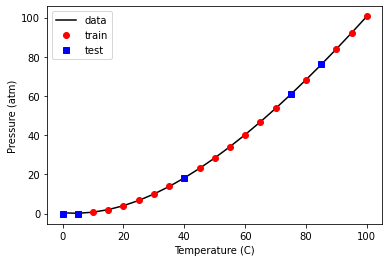

In [1]:
plt.plot(T, P, 'k-',
         X_train[:, 2], model.predict(X_train), 'ro',
         X_test[:, 2], model.predict(X_test), 'bs')
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (atm)')
plt.legend(['data', 'train', 'test']);

Now we have to figure out how to find an appropriate value for &alpha;. First, let's see how &alpha; affects the parameters. It is useful to search across a broad range of values, so we use a logspace to look at &alpha;=1e-15 to &alpha;=100.



In [1]:
import pandas as pd
import pickle
alpha = np.logspace(-15, 4, 10)

df = pd.DataFrame()

models = {}

for a in alpha:
    model = linear_model.Lasso(alpha=a, max_iter=50000)
    model.fit(X_train, y_train)
    df = df.append(pd.Series(model.coef_, name=a))
    models[a] = model

df

|              |         0 |        1 |         2 |   3 |
|--------------+-----------+----------+-----------+-----|
| 1.000000e-15 | -0.000040 | 0.014691 | -0.066078 | 0.0 |
| 1.291550e-13 | -0.000040 | 0.014691 | -0.066078 | 0.0 |
| 1.668101e-11 | -0.000040 | 0.014691 | -0.066078 | 0.0 |
| 2.154435e-09 | -0.000040 | 0.014691 | -0.066078 | 0.0 |
| 2.782559e-07 | -0.000040 | 0.014691 | -0.066078 | 0.0 |
| 3.593814e-05 | -0.000040 | 0.014690 | -0.066063 | 0.0 |
| 4.641589e-03 | -0.000039 | 0.014667 | -0.064901 | 0.0 |
| 5.994843e-01 | -0.000031 | 0.013303 | -0.000000 | 0.0 |
| 7.742637e+01 | -0.000029 | 0.013052 |  0.000000 | 0.0 |
| 1.000000e+04 |  0.000100 | 0.000000 |  0.000000 | 0.0 |

You can see that this eventually eliminates the parameter for column 2, which is the linear term.

Now we need to look at the trends in the quality of the model. One way to do this to evaluate the score



In [1]:
for a, pars in df.iterrows():
    model = models[a]
    print(model.score(X_train, y_train))

0.9999973502351318
0.9999973502351318
0.9999973502351317
0.999997350235111
0.9999973502324528
0.9999973496003345
0.9999972971538174
0.9999785178990158
0.9999565377622336
0.9559621585686436

Visually we can see that if &alpha; gets too large, it has a detrimental effect, but for some intermediate values we can have a more sparse model, e.g. $P = \beta_3 T^3 + \beta_2 T^2$.



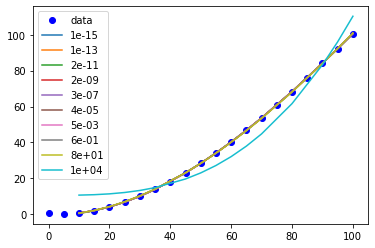

In [1]:
plt.plot(T, P, 'bo', label='data')
for a, pars in df.iterrows():
    model = models[a]
    x, y = X_train[:, 2], model.predict(X_train)
    i = np.argsort(x)
    plt.plot(x[i], y[i], '-', label=f'{a:1.0e}')

plt.legend();

There are still a few loose ends here. These results apply specifically to the train-test split we used, and that was chosen randomly. We would expect to get (slightly at least) different results with different choices. This is also a common machine learning problem, and next we will consider how to do many different fits with different train/test splits with a method called K-fold validation.

